Copyright 2023 IBM Inc. All rights reserved  
SPDX-License-Identifier: Apache-2.0

This Notebook is similar to `Examples.ipynb`, but it demonstrates the use of the scaling
capability in the `FunctionEstimator` and `DynamicalSystemEstimator` classes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25, 10)
import sklearn.preprocessing as skp
import rkhsid as RKHS
from rkhsid.kernels import RBF_kernel

## Scaling linearly to an interval
`IntervalScaler()` does exactly that: Given intervals $[a_i, b_i]$, $a_i<b_i$, it computes scalings $(m_i,c_i)$ so that the training data is mapped into $[a_1, b_1] \times [a_2, b_2] ...$ by $ x \mapsto [m_1 x_1 + c_1, m_2 x_2 + c_2, ...]$.  
A margin $r$ can be specified, so that the training data is mapped into the smaller intervals $[a_i+r(b_i-a_i), b_i-r(b_i-a_i)]$.  
Specifying a range `None` for a dimension means that no scaling is applied in this dimension (equivalently, $(m_i, c_i) = (1,0)$ for this dimension).

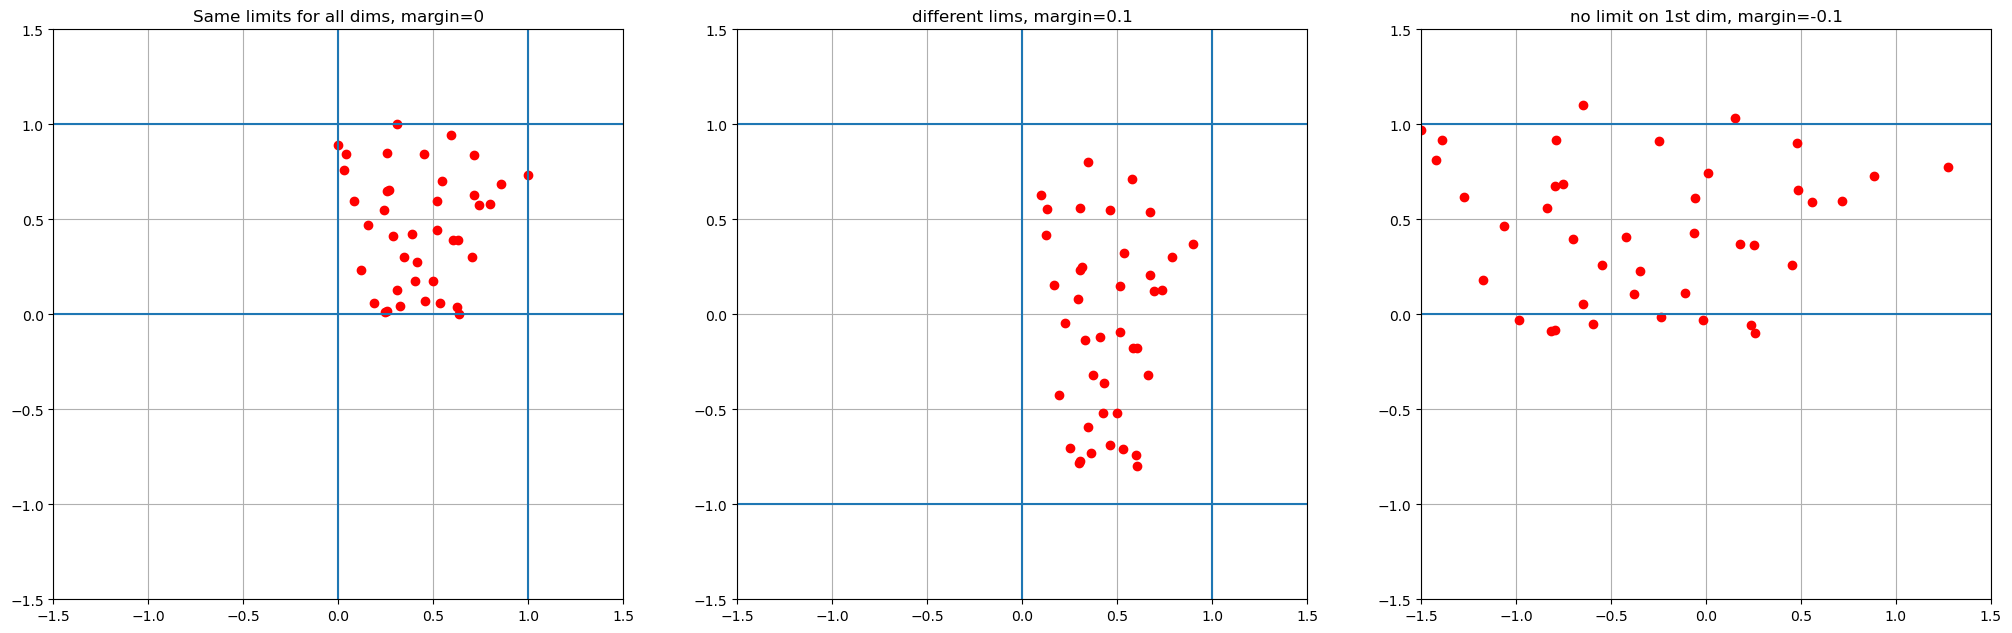

In [ ]:
x = (np.random.rand(40, 2) - 0.5) * 3

fig, ax = plt.subplots(1, 3)
for a, minmax, margin, title in zip(
    ax,
    ((0, 1), [(0, 1), (-1, 1)], [None, (0, 1)]),
    (0, 0.1, -0.1),
    ["Same limits for all dims", "different lims", "no limit on 1st dim"],
):
    scaler = RKHS.estimator.IntervalScaler(minmax=minmax, margin=margin, n=2)
    x_t = scaler.fit(x).transform(x)
    a.plot(x_t[:, 0], x_t[:, 1], "ro")
    a.set_title(title + f", margin={margin}")

    if hasattr(minmax[1], "__len__"):
        for m in minmax[1]:
            a.axhline(m)
        if minmax[0] is not None:
            for m in minmax[0]:
                a.axvline(m)
    else:
        for m in minmax:
            a.axhline(m)
            a.axvline(m)
    a.axis("square")
    a.axis([-1.5, 1.5, -1.5, 1.5])
    a.grid()

# Function estimation
First we use the `FunctionEstimator` to estimate simple functions -- not dynamical systems -- from data.

## Univariate functions
As the simplest, here's the estimation of a function $f(x)$ of a single variable. The independent variable is in $[-2,2]$, but we're using a kernel that is defined only on $[0,1]$.

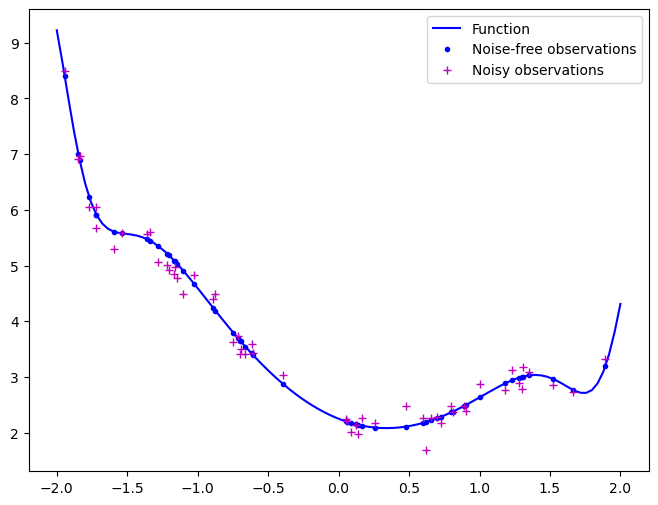

In [ ]:
xax = np.linspace(-2, 2, num=100)  # for plotting
func1 = (
    lambda x: (x - 0.5) ** 2
    + np.cos(np.pi * x**2 * (x - 0.1) ** 2 / 10)
    + np.sqrt(x**2 + 1)
)
# func1 = lambda x: 2*x - 1 + np.cos(np.pi*x)/2
# Observations
N_obsv = 55
x_obsv = (np.random.rand(N_obsv, 1) - 0.5) * 4
# NOTE: it is important that x_obsv has 2 dims, even if the last one is singleton

y_obsv = func1(x_obsv)
y_noisy_obsv = y_obsv + np.random.randn(N_obsv, 1) / 5

plt.plot(xax, func1(xax), "b", label="Function")
plt.plot(x_obsv, y_obsv, "b.", label="Noise-free observations")
plt.plot(x_obsv, y_noisy_obsv, "m+", label="Noisy observations")
plt.gcf().set_size_inches((8, 6))
plt.legend()

Text(0.5, 1.0, 'Using noisy observations')

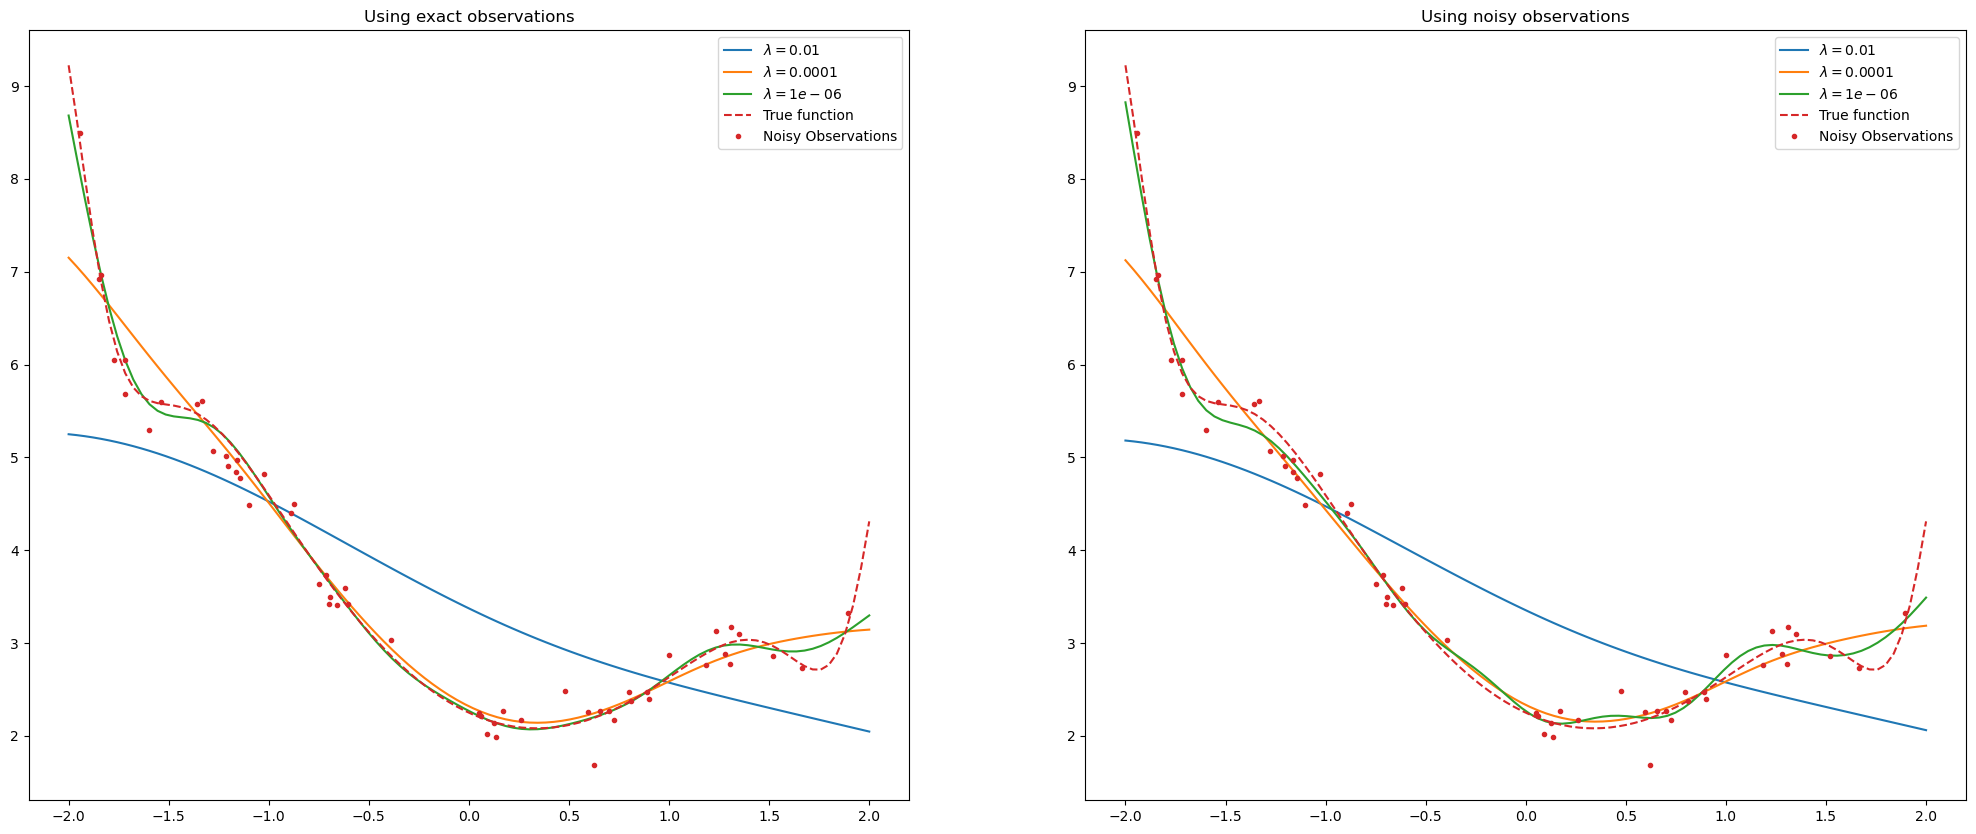

In [ ]:
# Bias space with constant and linear term
bias_eval = RKHS.linear_const_eval
# And the default Sine Kernel
sine_kernel = RKHS.SinKernel(max_freq=40)
# The sine kernel is valid for arguments in [0,1] only

funcest = RKHS.FunctionEstimator(
    bias_func_eval=bias_eval,
    kernel_func_eval=sine_kernel.eval,
    scaling=(0, 1),
    scale_margin=0.1,
)
# Change scaling to a larger interval, e.g. (-1,1), and observe that then, the estimation
# doesn't work well anymore

fig, ax = plt.subplots(1, 2)
for q in [1 / 100, 1 / 10000, 1 / 1000000]:
    funcest.fit(
        x_obsv, y_obsv, data_cost_weight=100 / N_obsv, rkhs_weight=q, bias_weight=0
    )
    ax[0].plot(xax, funcest.eval(xax[:, np.newaxis]), label=f"$\lambda={q}$")
    funcest.fit(
        x_obsv,
        y_noisy_obsv,
        data_cost_weight=100 / N_obsv,
        rkhs_weight=q,
        bias_weight=0,
    )
    ax[1].plot(xax, funcest.eval(xax[:, np.newaxis]), label=f"$\lambda={q}$")

# plt.plot(xax, funcest.eval(xax[:,np.newaxis]))
for a in ax:
    curr_line = a.plot(xax, func1(xax), "--", label="True function")
    a.plot(
        x_obsv,
        y_noisy_obsv,
        ".",
        color=curr_line[0].get_color(),
        label="Noisy Observations",
    )
    a.legend()
    a.axis("tight")
ax[0].set_title("Using exact observations")
ax[1].set_title("Using noisy observations")

## Bivariate function
The next example is a function $f(x,y)$ of two variables. The independent variables $(x,y)$ are in $[0,3]\times [0,2]$, but we're again using a kernel defined only on the unit square $[0,1]^2$.

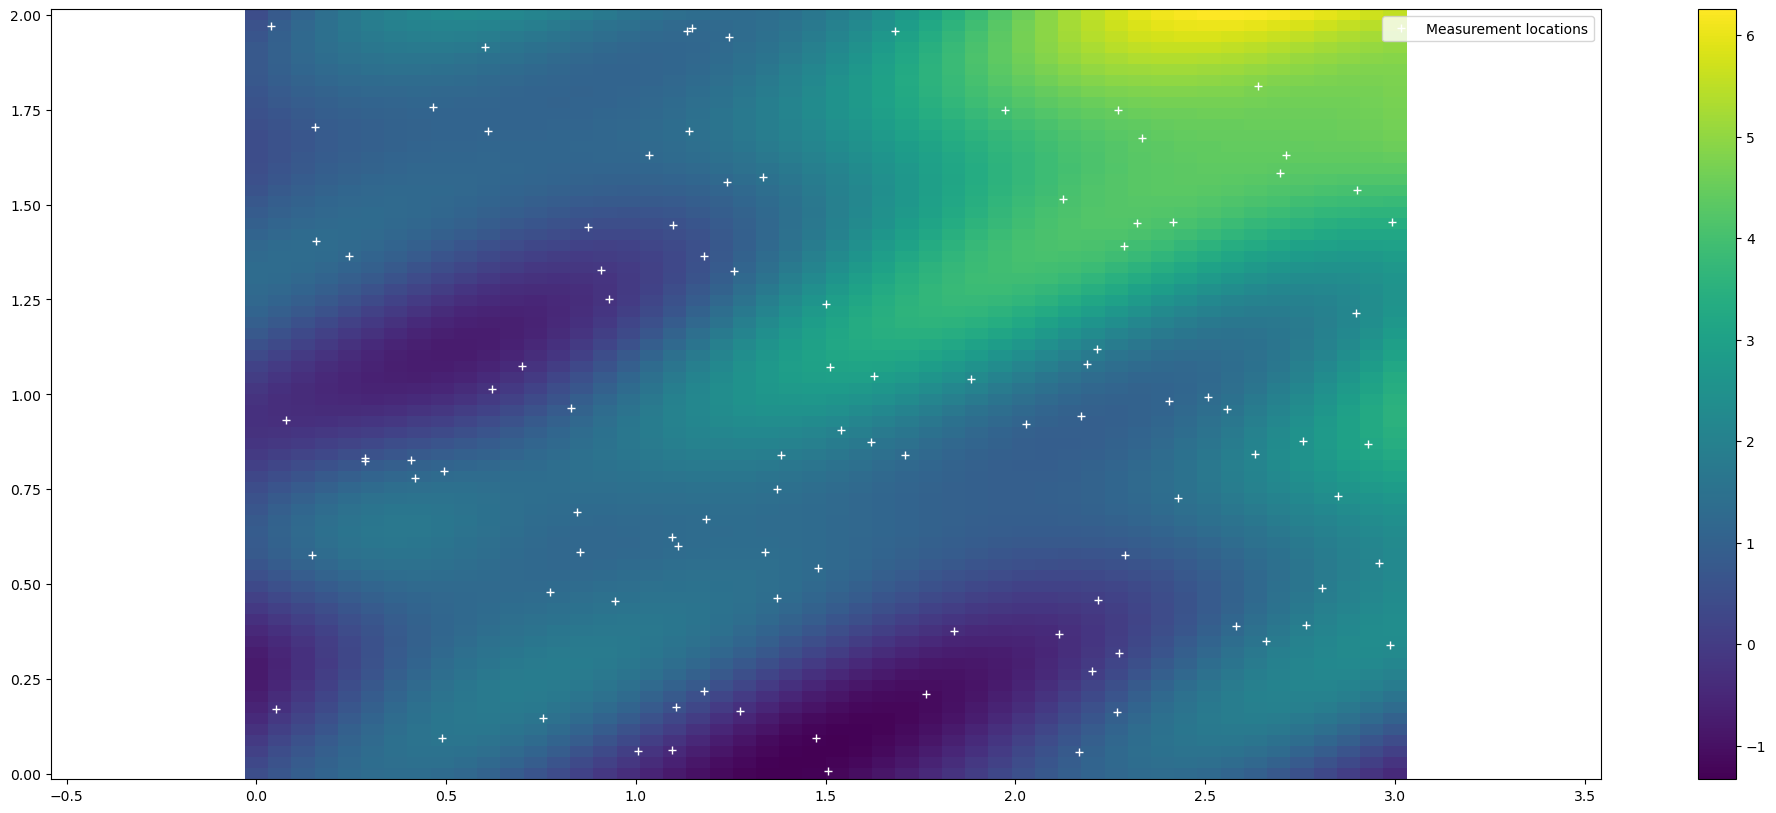

In [3]:
Nx, Ny = (50, 70)
X, Y = np.meshgrid(np.linspace(0, 3, Nx), np.linspace(0, 2, Ny))

func2 = (
    lambda x, y: x * y
    + np.sin(np.pi * (x - y))
    + np.cos(0.5 + 3 * np.pi * (-x / 3 + y)) / 2
    + 2 * np.exp(-5 * (x - 0.3) ** 2 - 10 * (y - 0.6) ** 2)
)

Z = func2(X, Y)
plt.pcolormesh(X, Y, Z, cmap="viridis")
plt.colorbar()

N_obsv = 100
X_obsv = np.random.rand(N_obsv, 2) * np.array([[3, 2]])
Y_obsv = func2(X_obsv[:, 0], X_obsv[:, 1])[:, np.newaxis]
plt.plot(X_obsv[:, 0], X_obsv[:, 1], "w+", label="Measurement locations")
# plt.gcf().set_size_inches((10,8))
plt.axis("equal")
# plt.axis('tight')
plt.legend()

Define the `FunctionEstimator` object and fit. We're specifying the scaling here using a Scaler from `scikit-learn`, just to demonstrate this additional way to specify a scaling.

In [21]:
# Bias space with constant and linear term
bias_eval = RKHS.linear_const_eval
# And the default Sine Kernel
sine_kernel2 = RKHS.SinKernel(max_freq=20)
# And a scikit-learn scaler, just to demonstrate
mm_scaler = skp.MinMaxScaler(feature_range=(0, 1))

funcest2 = RKHS.FunctionEstimator(
    bias_func_eval=bias_eval,
    kernel_func_eval=sine_kernel2.eval,
    # kernel_func_eval=RBF_kernel,
    scaling=mm_scaler,
    scale_margin=0.1,  # scale_margin is only used when intervals are given
)

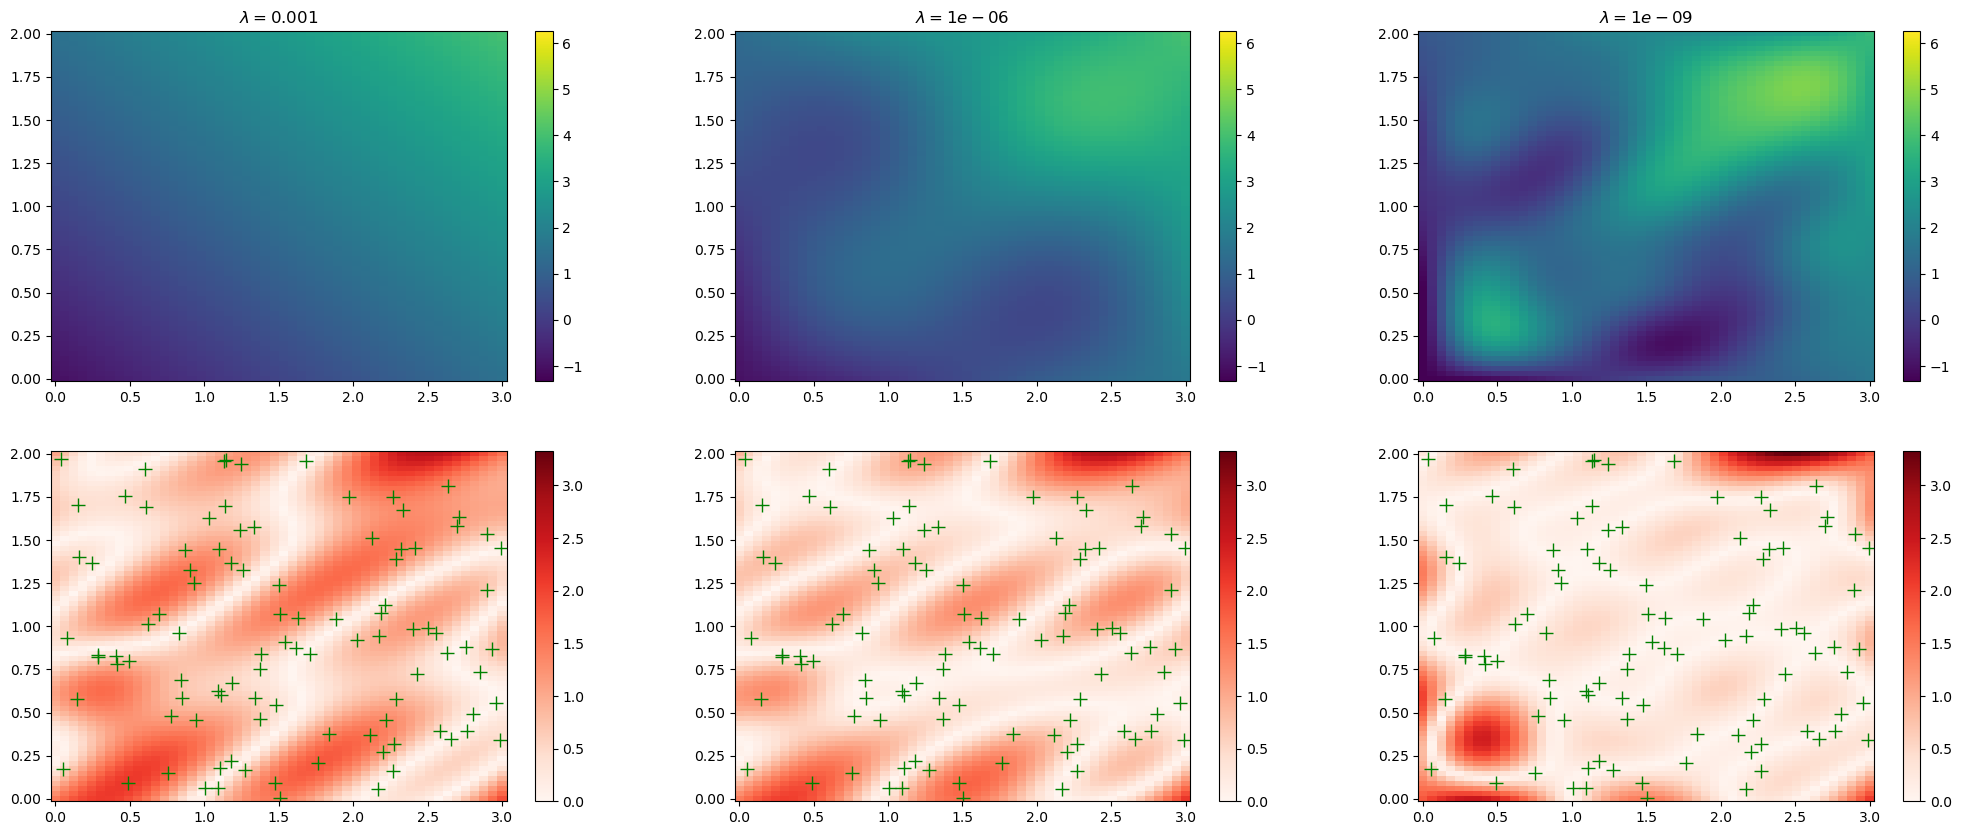

In [22]:
max_diff = 0
max_z, min_z = (-np.inf, np.inf)  # to scale the colormaps
pcm_z = []
pcm_diff = []
fig, ax = plt.subplots(2, 3)
for ii, q in enumerate([1 / 1_000, 1 / 1_000_000, 1 / 1_000_000_000]):
    funcest2.fit(X_obsv, Y_obsv, data_cost_weight=1, rkhs_weight=q)
    Zest = funcest2.eval(np.column_stack((X.flatten(), Y.flatten()))).reshape(X.shape)
    pcm = ax[0, ii].pcolormesh(X, Y, Zest, cmap="viridis")
    pcm_z.append(pcm)
    # plt.colorbar(pcm, ax=ax[0,ii])
    ax[0, ii].set_title(f"$\lambda={q}$")
    pcm = ax[1, ii].pcolormesh(X, Y, np.abs(Z - Zest), cmap="Reds")
    # plt.colorbar(pcm, ax=ax[1,ii])
    pcm_diff.append(pcm)
    ax[1, ii].plot(X_obsv[:, 0], X_obsv[:, 1], "g+", markersize=10)

    max_diff = max(max_diff, np.max(np.abs(Z - Zest)))
    min_z = min(min_z, np.min(Zest))
    max_z = max(max_z, np.max(Zest))

for ia in range(3):
    # set all the colormaps to the same limits and add colorbars
    pcm_z[ia].set_clim((np.min(Z), np.max(Z)))  # min_z, max_z))
    plt.colorbar(pcm_z[ia], ax=ax[0, ia])
    pcm_diff[ia].set_clim((0, max_diff))
    plt.colorbar(pcm_diff[ia], ax=ax[1, ia])

for a in ax.flat:
    a.axis("equal")
    a.axis("tight")

# System Identification
`Examples.ipynb` specifies a more extensive list of example functions, we focus here only on 2.
* Scalar system with exogenous input, i.e. $x[t+1] = M( x[t], ..., x[t-m+1], u[t], ..., u[t-k+1])$
* Multi-dimensional system with exogenous inputs, i.e. $X[t+1] = ( M_1(X[t], ..., U[t], ...), M_2(X[t], ..., U[t]), ..., M_d(X[t], ..., U[t]) )$

### System definitions and data generation
Note: the same exogenous inputs `U` are used for all of the non-autonomous systems, for convenience.

In [8]:
## System definitions
# scalar i/o systems
def arx1(a=0.5, b=0.25):
    # just a scalar arx(1) system
    return lambda x, u: a * x + b * u


def narx1(a=0.5, b=0.25, c=0.3):
    # linear arx(1) system, plus a nonlinearity with delay=2
    lin = arx1(a, b)
    return lambda x1x2, u: lin(x1x2[1], u) + c * x1x2[0] ** 3


# VAR with delay 2
def varx2(
    A=(np.array([[0.5, 0.2], [-0.1, 0.75]]), np.array([[0.2, -0.2], [0.5, 0.05]])),
    B=(np.array([[1], [-1]]), np.array([[0.1], [-0.1]])),
):
    # Multi-ouput ARX(2) system
    rhs = lambda X12, U12: A[0] @ X12[1] + A[1] @ X12[0] + B[0] @ U12[1] + B[1] @ U12[0]
    rhs.A0 = A[0]
    rhs.A1 = A[1]
    rhs.B0 = B[0]
    rhs.B1 = B[1]
    rhs.n = A[0].shape[0]
    rhs.nu = B[0].shape[1]
    return rhs

In [9]:
## Data generation
N_traj = 3  # number of trajectories to generate for all the systems
T = 25  # length of generated trajectories
rhs2 = narx1()
rhs4 = varx2()
Y2 = []
Y4 = []
U = []

for pp in range(N_traj):
    # pre-allocate trajectories and add initial values
    y2 = np.zeros((T, 1)) + np.nan
    y2[:2, [0]] = np.random.rand(2, 1)
    y4 = np.zeros((T, 2)) + np.nan
    y4[:2, :] = np.random.rand(2, 2)
    # input signal
    U.append(np.random.rand(T, 1))
    for tt in range(T - 2):
        y2[tt + 2, :] = rhs2(y2[tt : tt + 2, :], U[pp][tt + 1, :])
        y4[tt + 2, :] = rhs4(y4[tt : tt + 2, :], U[pp][tt : tt + 2, :])
    Y2.append(y2)
    Y4.append(y4)

Text(0.5, 1.0, 'VARX, inputs')

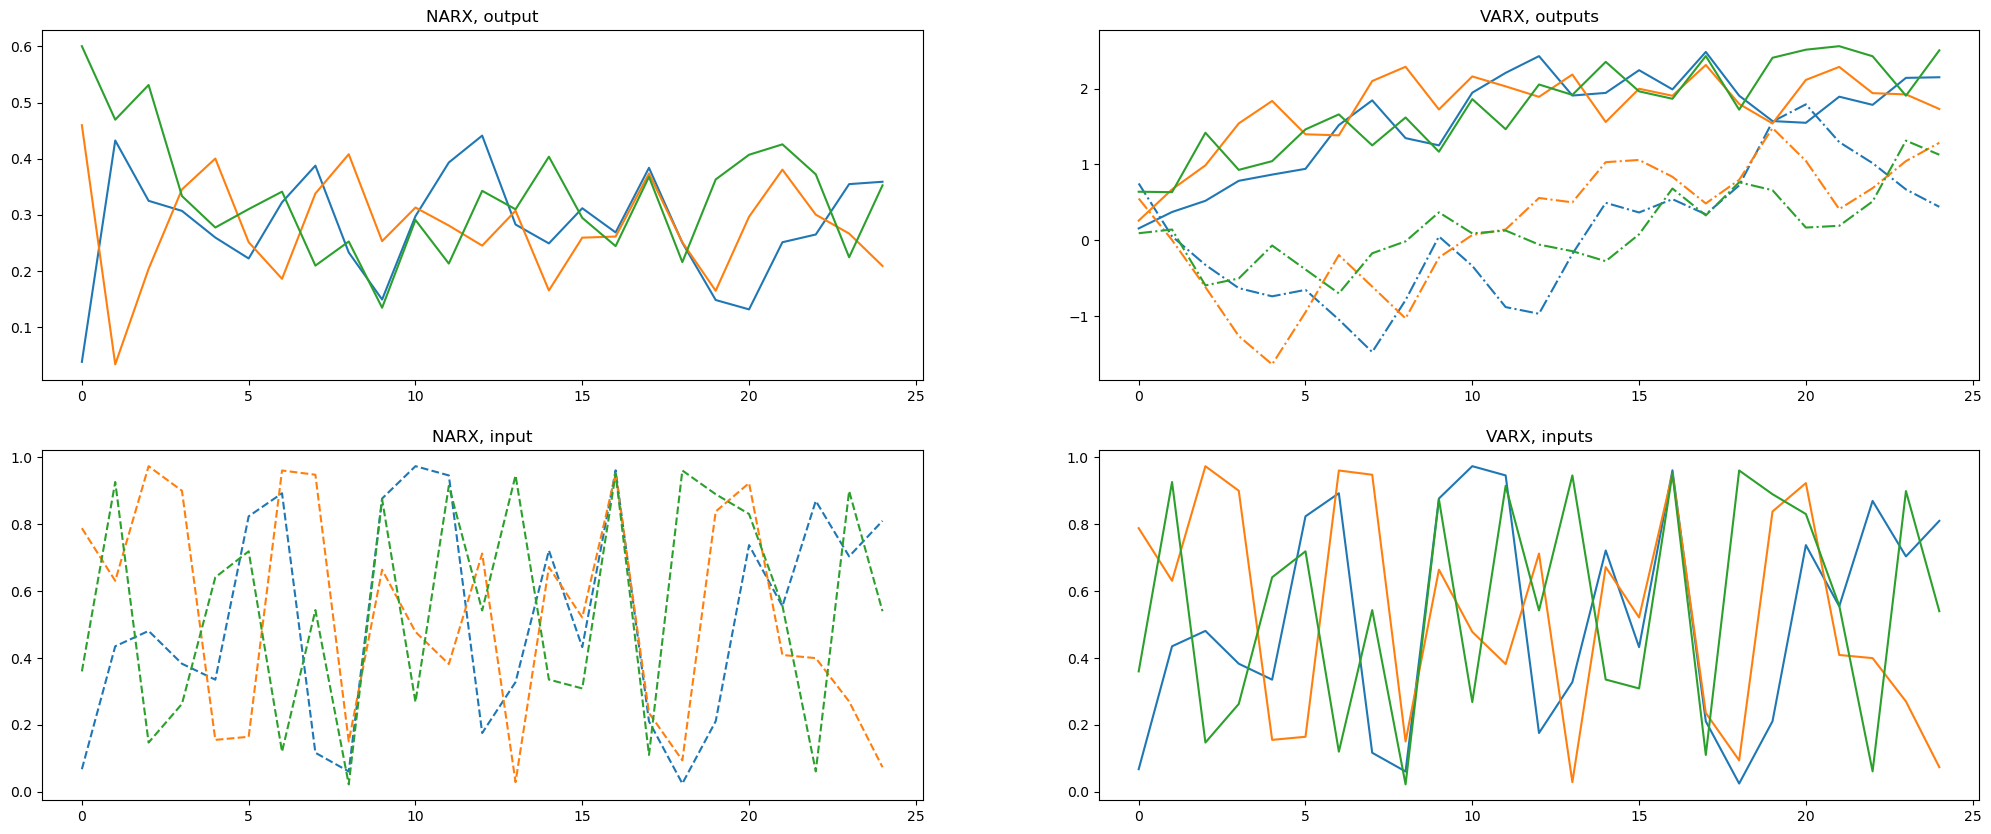

In [11]:
## Plotting the training data
fig, ax = plt.subplots(2, 2)
for y, u in zip(Y2, U):
    curr_line = ax[0, 0].plot(y)
    ax[1, 0].plot(u, "--", color=curr_line[0].get_color())
ax[0, 0].set_title("NARX, output")
ax[1, 0].set_title("NARX, input")
for y, u in zip(Y4, U):
    curr_line = ax[0, 1].plot(y[:, 0])
    ax[0, 1].plot(y[:, 1], "-.", color=curr_line[0].get_color())
    ax[1, 1].plot(u, "-", color=curr_line[0].get_color())
ax[0, 1].set_title("VARX, outputs")
ax[1, 1].set_title("VARX, inputs")

### Estimation
The dynamical system estimation is handled by the `DynamicalSystemEstimator` object.  
It provides a few convenience methods, e.g. `simulate` and `k_step_ahead`.
Note that the VAR-based estimators don't (yet) support scaling; since the domain of linear 
functions is unrestricted anyways, it isn't urgently necessary to add this functionality.

Be careful with `max_freq` and the specified delays, in combination with the output and input
dimensions, the computations blow up quickly and might lead to kernel crashes.

In [16]:
bias_eval3 = RKHS.linear_const_eval
sine_kernel3 = RKHS.SinKernel(max_freq=5)
dynest_increment = RKHS.DynamicalSystemEstimator(
    bias_func_eval=bias_eval3,
    kernel_func_eval=sine_kernel3.eval,
    target_increment=True,
    y_scaling=(-1, 1),
    y_scale_margin=0.1,
    exo_scaling=(-1, 1),
    exo_scale_margin=0.1,
)
# The VAR estimators don't support scaling yet, it's likely not necessary for them.

# Try mis-matching the delays with the true model to see what happens if the delays are selected incorrectly
exo_delays = 1  # true value is 2
traj_delays = 1  # true value is 2

# Fit and simulate
Y_to_fit = Y4
dynest_increment.fit(
    Y_to_fit[:2], exogenous_inputs=U[:2], exo_delays=exo_delays, traj_delays=traj_delays
)
y_lin_sim_increment = dynest_increment.simulate(
    [y[: max(traj_delays, exo_delays), :] for y in Y_to_fit], exogenous_inputs=U
)

Text(0.5, 1.0, 'traj_delays=1, exo_delays=1 (True delays are (2,2))')

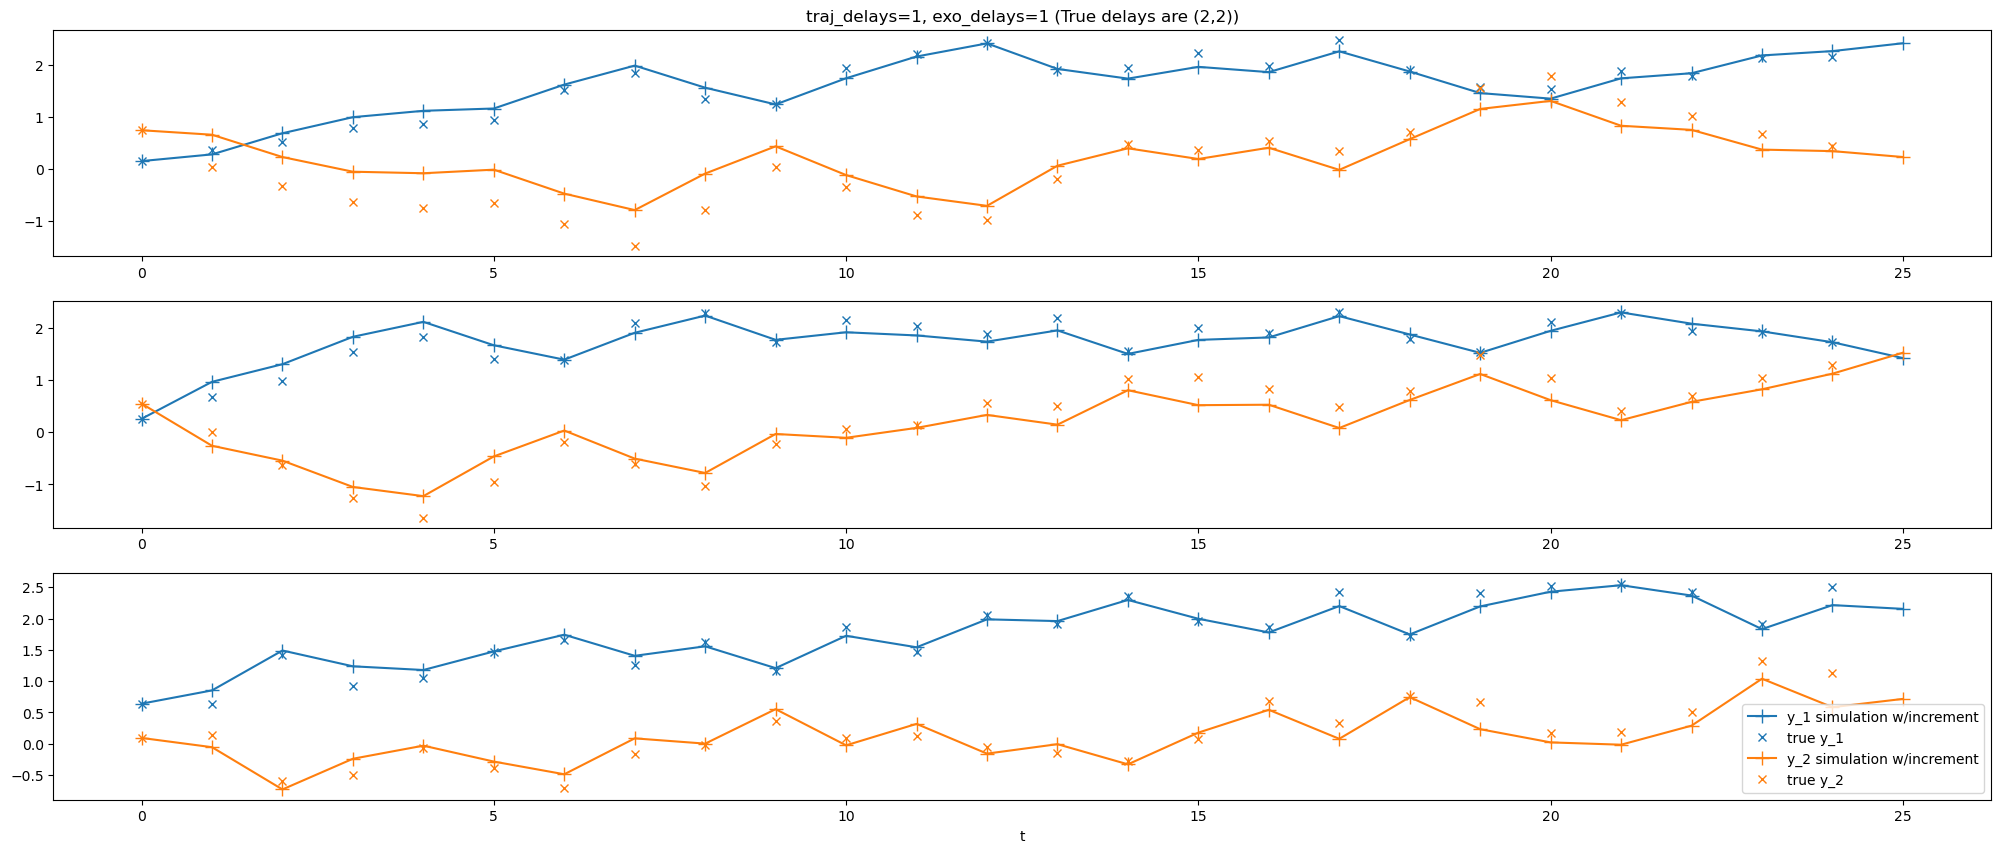

In [17]:
# Plot results
fig, ax = plt.subplots(3, 1)
for ii in range(3):
    for nn in range(2):
        curr_line = ax[ii].plot(
            y_lin_sim_increment[ii][:, nn],
            "-+",
            label=f"y_{nn+1} simulation w/increment",
            ms=10,
        )
        # for cl in curr_line: cl.set_color(curr_line[0].get_color())
        ax[ii].plot(
            Y_to_fit[ii][:, nn],
            "x",
            label=f"true y_{nn+1}",
            color=curr_line[0].get_color(),
        )
plt.legend()
plt.xlabel("t")
ax[0].set_title(
    f"traj_delays={traj_delays}, exo_delays={exo_delays} (True delays are (2,2))"
)

### Add some noise to the measurements 

In [18]:
bias_eval = RKHS.linear_const_eval
sine_kernel = RKHS.SinKernel(max_freq=15)
dynest_increment = RKHS.DynamicalSystemEstimator(
    bias_func_eval=bias_eval,
    kernel_func_eval=sine_kernel.eval,
    target_increment=True,
    y_scaling=(-1, 1),
    y_scale_margin=0.1,
    exo_scaling=(-1, 1),
    exo_scale_margin=0.1,
)

# Try mis-matching the delays with the true model to see what happens if the delays are selected incorrectly
exo_delays = 1  # true value is 1
traj_delays = 1  # true value is 1

# Noise
rng = np.random.default_rng(3141515)
noise_variance = 0.02
Y2_noise = [y + rng.standard_normal(size=y.shape) * noise_variance for y in Y2]

dynest_increment.fit(
    Y2_noise[:2],
    exogenous_inputs=U[:2],
    exo_delays=exo_delays,
    traj_delays=traj_delays,
    data_cost_weight=10,
    bias_weight=0,
    rkhs_weight=1,
)

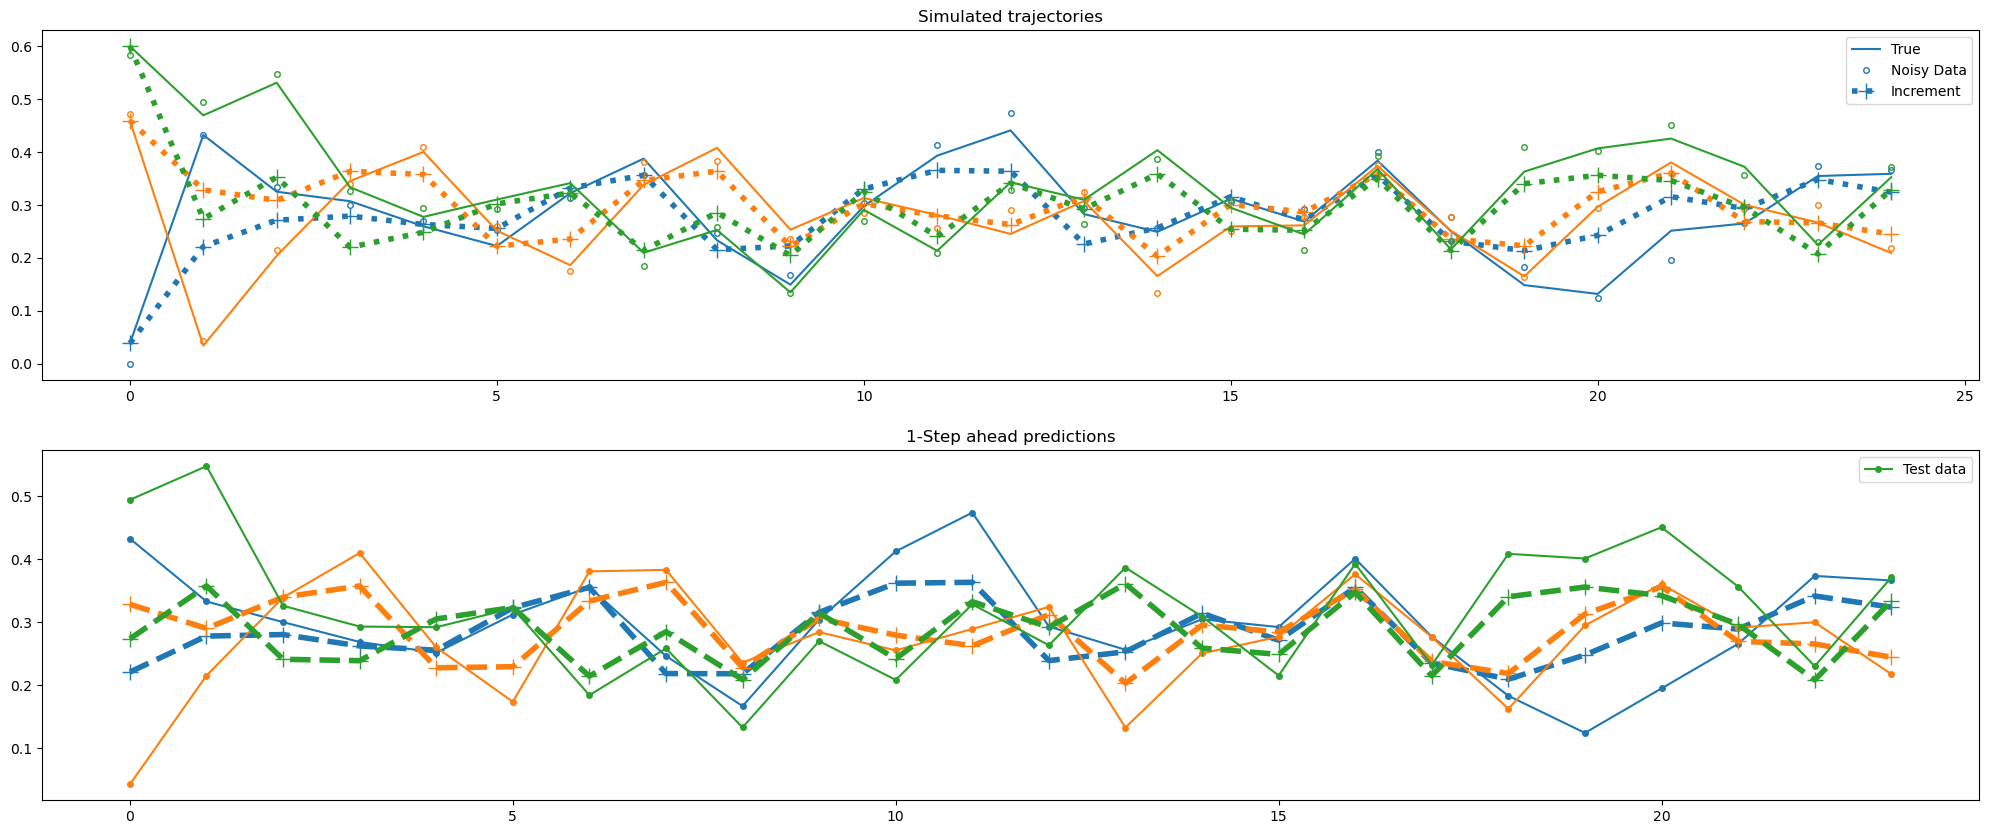

In [19]:
fig, ax = plt.subplots(2, 1)
# plot simulations
Y2_simulated_increment = dynest_increment.simulate(
    [y[[0], :] for y in Y2], exogenous_inputs=U, traj_len=T
)

ax[0].set_title("Simulated trajectories")
for y, y_noisy, ysim_increment in zip(Y2, Y2_noise, Y2_simulated_increment):
    curr_line = ax[0].plot(y[:, 0], "-", ms=4, label="True")
    ax[0].plot(
        y_noisy[:, 0],
        "o",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=4,
        label="Noisy Data",
    )
    ax[0].plot(
        ysim_increment[:, 0],
        ":+",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=12,
        lw=4,
        label="Increment",
    )

ax[0].legend(["True", "Noisy Data", "Increment"])
# k-step ahead
k_ahead = 1
Y2_kstep_increment = dynest_increment.k_step_ahead(Y2, exogenous_inputs=U, k=k_ahead)

ax[1].set_title(f"{k_ahead}-Step ahead predictions")
for y, ystep_increment in zip(Y2_noise, Y2_kstep_increment):
    curr_line = ax[1].plot(y[k_ahead:, 0], "-o", ms=4)
    ax[1].plot(
        ystep_increment[:, 0],
        "--+",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=12,
        lw=4,
    )
curr_line[0].set_label("Test data")  # the last traj. wasn't used for training
ax[1].legend()

_Copyright IBM Corp. 2023_

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.